In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.special import erfc
import pandas as pd

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [2]:
def prob_template_given_mag(fraction, kt, magnitude):
    """
    | Spectral type | Fraction | kt    |
    |---------------|----------|-------|
    | E/SO          | 0.35     | 0.147 |
    | Spirals       | 0.50     | 0.450 |
    | Irregulars    | 0.15     |       |
    """
    expterm = kt * (magnitude - 20.0)
    return fraction * np.exp(-expterm)

def prob_redshift_given_template_mag(redshift, magnitude, alpha, redshift_ref, kmt):
    """
    See table from Benitez (2000). 
    
    | Spectral type | alpha | redshift reference | kmt    |
    |---------------|-------|--------------------|--------|
    | E/SO          | 2.46  | 0.431              | 0.091  |
    | Spirals       | 1.81  | 0.390              | 0.0636 |
    | Irregulars    | 0.91  | 0.063              | 0.123  |
    """
    zmt = redshift_ref + kmt * (magnitude - 20)
    probability = redshift**alpha * np.exp(- (redshift / zmt)**alpha)
    norm = np.trapz(probability, redshift)
    return probability / norm

def prob_redshift_given_mag(redshift, magnitude):

    p_temp_eso = prob_template_given_mag(0.35, 0.147, magnitude)
    p_temp_spi = prob_template_given_mag(0.50, 0.45, magnitude)
    p_temp_irr = 1 - (p_temp_eso + p_temp_spi)
    
    probability_eso = prob_redshift_given_template_mag(redshift, magnitude, 2.46, 0.431, 0.091)
    probability_spi = prob_redshift_given_template_mag(redshift, magnitude, 1.81, 0.390, 0.0636)
    probability_irr = prob_redshift_given_template_mag(redshift, magnitude, 0.91, 0.063, 0.123)

    probability = p_temp_eso * probability_eso + p_temp_spi * probability_spi + p_temp_irr * probability_irr
    probability = probability / np.trapz(probability, redshift)
    return probability

# Plot Distributions

In [3]:
# the fine bin for redshift 
z_grid_binsize = 0.001
z_grid_edges = np.arange(0.0, 3.0, z_grid_binsize)
z_grid = (z_grid_edges[1:] + z_grid_edges[:-1])/2.

# the magnitude
magnitude = 22.0 

In [4]:
p_temp_eso = prob_template_given_mag(0.35, 0.147, magnitude)
p_temp_spi = prob_template_given_mag(0.50, 0.45, magnitude)
p_temp_irr = 1 - (p_temp_eso + p_temp_spi)

In [5]:
probability_eso = prob_redshift_given_template_mag(z_grid, 22, 2.46, 0.431, 0.091)
probability_spi = prob_redshift_given_template_mag(z_grid, 22, 1.81, 0.390, 0.0636)
probability_irr = prob_redshift_given_template_mag(z_grid, 22, 0.91, 0.063, 0.123)
prob_z_given_mag = prob_redshift_given_mag(z_grid, 22)

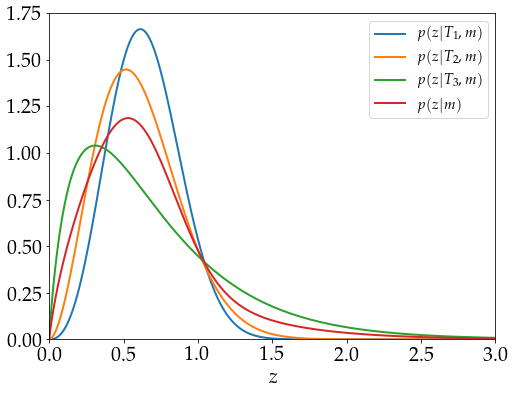

In [6]:
plt.figure(figsize = (8,6))
plt.plot(z_grid, probability_eso, lw = 2, label = r'$p(z|T_{1}, m)$')
plt.plot(z_grid, probability_spi, lw = 2, label = r'$p(z|T_{2}, m)$')
plt.plot(z_grid, probability_irr, lw = 2, label = r'$p(z|T_{3}, m)$')
plt.plot(z_grid, prob_z_given_mag, lw = 2, label = r'$p(z|m)$')
plt.xlim(min(z_grid)-0.001, max(z_grid)+0.002)
plt.ylim(0, 1.75)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

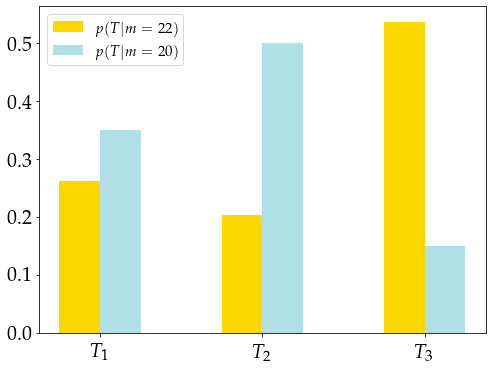

In [7]:
barWidth = 0.25
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]

plt.figure(figsize=(8,6))
plt.bar(br1, [p_temp_eso, p_temp_spi, p_temp_irr], width = barWidth, label = r'$p(T|m=22)$', color = 'gold')
plt.bar(br2, [0.35, 0.50, 0.15], width = barWidth, label = r'$p(T|m=20)$',  color = 'powderblue')
plt.xticks([r + 0.5*barWidth for r in range(3)], [r'$T_{1}$', r'$T_{2}$', r'$T_{3}$'])
plt.tick_params(axis='x', labelsize=fontSize, pad=10)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

# Filters

In [8]:
def interpolate_filters(folder: str, fnames: list, nwave: int=1000):
    filters = dict()
    filters_int = dict()
    record_min = list()
    record_max = list()
    for file in fnames:
        filterband = np.loadtxt(f'{folder}/{file}')[:,[0,1]]
        wavelength = filterband[:,0]
        record_min.append(min(wavelength))
        record_max.append(max(wavelength))
        filters[file.split('.')[0]] = filterband
        
    minwave = min(record_min)
    maxwave = max(record_max)
    waveint = np.linspace(minwave, maxwave, nwave)
    
    for key, value in filters.items():
        func = interp1d(value[:,0], value[:,1], bounds_error=False, kind='linear',
                        fill_value=(value[:,1][0], value[:,1][-1]))
        ynew = func(waveint)
        filters_int[key] = ynew
    filters_int['wavelength'] = waveint
    
    return filters_int

In [9]:
filternames = ['u.dat', 'g.dat', 'r.dat', 'i.dat', 'z.dat']
filters_int = interpolate_filters('filters', filternames, 1000)

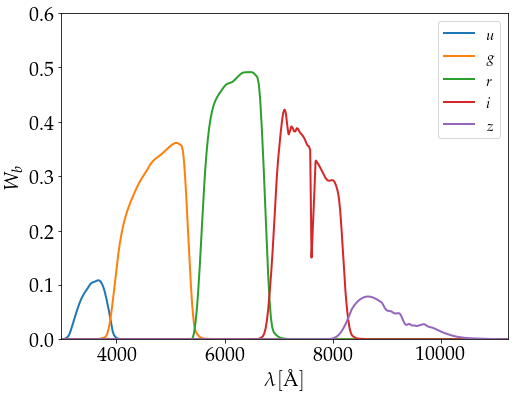

In [10]:
plt.figure(figsize = (8, 6))
plt.plot(filters_int['wavelength'], filters_int['u'], label = r'$u$', lw = 2)
plt.plot(filters_int['wavelength'], filters_int['g'], label = r'$g$', lw = 2)
plt.plot(filters_int['wavelength'], filters_int['r'], label = r'$r$', lw = 2)
plt.plot(filters_int['wavelength'], filters_int['i'], label = r'$i$', lw = 2)
plt.plot(filters_int['wavelength'], filters_int['z'], label = r'$z$', lw = 2)
plt.ylim(0.0, 0.6)
plt.xlim(min(filters_int['wavelength']), max(filters_int['wavelength']))
plt.xlabel(r'$\lambda [\textrm{\AA}]$', fontsize = fontSize)
plt.ylabel(r'$W_{b}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

# Templates

In [14]:
def process_templates(folder, waverange: list, nwave: int = 1000, normwave=7E3):
    """
    Process the templates in such a way that they are normalised at wavelength=7000 angstrom. They are 
    also interpolated in the range of the wavelength of the filters, that is, between 2980.0 and 11230.0. 
    """
    waveint = np.linspace(waverange[0], waverange[1], nwave)
    templates = dict()
    seds = os.listdir('seds/')
    for f in seds:
        file = np.loadtxt(f'seds/{f}')
        wavelength = file[:, 0]
        sed = file[:,1] * file[:,0]**2
        norm_constant = np.interp(normwave, wavelength, sed)
        sed = sed / norm_constant
        func = interp1d(wavelength, sed, bounds_error=False, kind='linear', fill_value=(sed[0], sed[-1]))
        ynew = func(waveint)
        templates[f.split('.')[0]] = ynew
    templates['wavelength'] = waveint
    return templates

In [17]:
# filenames for the templates 
template_fnames = os.listdir('seds/')
templatenames = [f.split('.')[0] for f in template_fnames]

# ellipticals = ['El_B2004a.sed']
# spirals = ['Sbc_B2004a.sed','Scd_B2004a.sed']
# irregulars = ['Im_B2004a.sed','SB3_B2004a.sed','SB2_B2004a.sed', 'ssp_25Myr_z008.sed','ssp_5Myr_z008.sed']

# process templates 
waverange = (filters_int['wavelength'][0], filters_int['wavelength'][-1])
templates = process_templates('seds/', waverange, 1000, 7.5E3)

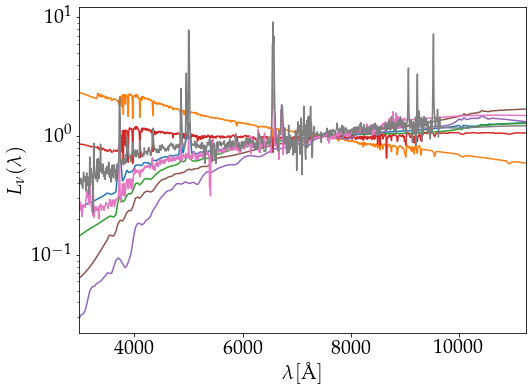

In [18]:
plt.figure(figsize=(8,6))
for fname in templatenames:
    plt.plot(templates['wavelength'], templates[fname])
plt.xlabel(r'$\lambda [\textrm{\AA}]$', fontsize = fontSize)
plt.ylabel(r'$L_{\nu}(\lambda)$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(waverange[0], waverange[1])
plt.yscale('log')
plt.show()